# AI Solicitor: SMS Spam Detection

In [1]:
!pip install torch transformers scikit-learn pandas numpy nltk textblob seaborn matplotlib wordcloud imblearn

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import class_weight
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
import nltk
from textblob import TextBlob
from wordcloud import WordCloud
import re
import warnings
warnings.filterwarnings('ignore')

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

In [ ]:
# Load and explore the dataset
dataset = pd.read_csv("Datasets/spam (1).csv", encoding='latin1')
dataset = dataset.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'])
dataset.head()

In [ ]:
# Basic dataset information
print("Dataset shape:", dataset.shape)
print("\nClass distribution:")
print(dataset['v1'].value_counts())
print("\nFirst few rows:")
print(dataset.head())

## Advanced Text Preprocessing Pipeline for SMS Data

### Stage 1: Initial Text Cleaning

In [ ]:
# Prepare the text data for preprocessing
X = dataset['v2']  # SMS messages
y = dataset['v1']  # Labels (spam/ham)

# Convert to lowercase
X = X.str.lower()

# Replace URLs with <URL>
X = X.str.replace(r'http\S+|www\S+|https\S+', '<url>', case=False, regex=True)

# Replace emails with <EMAIL>
X = X.str.replace(r'\S+@\S+', '<email>', case=False, regex=True)

# Replace phone numbers with <PHONE>
X = X.str.replace(r'\+?\d[\d -]{8,12}\d', '<phone>', case=False, regex=True)

# Replace monetary amounts with <MONEY>
X = X.str.replace(r'\$\d+(\.\d{2})?', '<money>', regex=True)

# Replace percentages with <PERCENTAGE>
X = X.str.replace(r'\d+%', '<percentage>', regex=True)

# Handle encoding issues
X = X.str.encode('utf-8', errors='ignore').str.decode('utf-8')

print("Sample preprocessed messages:")
for i in range(3):
    print(f"{i+1}: {X.iloc[i]}")

### Stage 2: SMS-Specific Preprocessing

In [ ]:
# Define common SMS abbreviations
abbreviations = {
    "u": "you",
    "ur": "your",
    "btw": "by the way",
    "idk": "i don't know",
    "imo": "in my opinion",
    "brb": "be right back",
    "lol": "laughing out loud",
    "omg": "oh my god",
    "ttyl": "talk to you later",
    "thx": "thanks",
    "pls": "please",
    "gr8": "great",
    "b4": "before",
    "l8r": "later",
    "cya": "see you",
    "np": "no problem",
    "smh": "shaking my head",
    "fyi": "for your information",
    "asap": "as soon as possible",
    "tbh": "to be honest",
    "jk": "just kidding",
    "rofl": "rolling on the floor laughing",
    "wtf": "what the fuck",
    "yolo": "you only live once",
    "bff": "best friends forever",
    "irl": "in real life",
    "dm": "direct message",
    "ftw": "for the win",
    "fomo": "fear of missing out",
    "tmi": "too much information",
    "ily": "i love you",
    "xoxo": "hugs and kisses",
    "wyd": "what are you doing",
    "hbu": "how about you",
    "ikr": "i know right",
    "nvm": "never mind",
    "ppl": "people",
    "sry": "sorry",
    "ty": "thank you",
    "yw": "you're welcome",
    "bc": "because",
    "cuz": "because",
    "bday": "birthday",
    "msg": "message",
    "txt": "text",
    "pic": "picture",
    "vid": "video",
    "atm": "at the moment",
    "bbl": "be back later",
    "fml": "fuck my life",
    "tysm": "thank you so much"
}

# Expand abbreviations
def expand_abbreviations(text):
    words = text.split()
    expanded_words = []
    for word in words:
        # Check if word is an abbreviation (case insensitive)
        if word.lower() in abbreviations:
            expanded_words.append(abbreviations[word.lower()])
        else:
            expanded_words.append(word)
    return ' '.join(expanded_words)

# Apply abbreviation expansion
X = X.apply(expand_abbreviations)

# Reduce duplicate characters (e.g., "sooooo" -> "so")
X = X.str.replace(r'(.)\1{2,}', r'\1\1', regex=True)

print("Sample messages after SMS-specific preprocessing:")
for i in range(3):
    print(f"{i+1}: {X.iloc[i]}")

### Stage 3: Advanced Linguistic Processing

In [ ]:
# Tokenize using BERT tokenizer (this is the key fix to avoid the previous error)
from transformers import DistilBertTokenizer

# Initialize the tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Tokenize the text data
def tokenize_text(texts, max_length=128):
    """Tokenize texts using DistilBERT tokenizer"""
    # Ensure we're working with a list of strings
    if isinstance(texts, pd.Series):
        texts = texts.tolist()
    
    # Tokenize with truncation and padding
    encodings = tokenizer(
        texts,
        truncation=True,
        padding=True,
        max_length=max_length,
        return_tensors='pt'
    )
    
    return encodings

# Apply tokenization to our preprocessed messages
tokenized_data = tokenize_text(X)

print("Tokenized data keys:", tokenized_data.keys())
print("Input IDs shape:", tokenized_data['input_ids'].shape)
print("Attention mask shape:", tokenized_data['attention_mask'].shape)
print("Sample tokenized input IDs:", tokenized_data['input_ids'][0][:10])

## Model Architecture Design

In [ ]:
# Define the classification model
import torch
import torch.nn as nn

class SpamHamClassifier(nn.Module):
    def __init__(self, model_name='distilbert-base-uncased', num_labels=2, dropout_rate=0.3):
        super(SpamHamClassifier, self).__init__()
        # Load the pre-trained DistilBERT model
        self.distilbert = DistilBertForSequenceClassification.from_pretrained(
            model_name, 
            num_labels=num_labels,
            hidden_dropout_prob=dropout_rate,
            attention_probs_dropout_prob=dropout_rate
        )
        
        # We'll use the classification head from DistilBERT directly
        # But we can add additional layers if needed
        
    def forward(self, input_ids, attention_mask):
        outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        return outputs.logits

# Initialize the model
model = SpamHamClassifier()

# Check device availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Move model to device
model = model.to(device)

## Data Preparation and Splitting

In [ ]:
# Prepare the dataset for training
# Convert labels to integers
labels = torch.tensor([1 if label == 'spam' else 0 for label in y])

# Split the data into training and validation sets (70/30 split)
train_inputs, val_inputs, train_labels, val_labels = train_test_split(
    tokenized_data['input_ids'].numpy(),
    labels.numpy(),
    test_size=0.3,
    random_state=42,
    stratify=labels.numpy()
)

# Convert to PyTorch tensors
train_inputs = torch.tensor(train_inputs)
val_inputs = torch.tensor(val_inputs)
train_labels = torch.tensor(train_labels)
val_labels = torch.tensor(val_labels)

# Create attention masks
train_masks = torch.tensor((train_inputs != tokenizer.pad_token_id).long())
val_masks = torch.tensor((val_inputs != tokenizer.pad_token_id).long())

print("Training set:")
print(f"  Input IDs shape: {train_inputs.shape}")
print(f"  Attention masks shape: {train_masks.shape}")
print(f"  Labels shape: {train_labels.shape}")

print("\nValidation set:")
print(f"  Input IDs shape: {val_inputs.shape}")
print(f"  Attention masks shape: {val_masks.shape}")
print(f"  Labels shape: {val_labels.shape}")

# Create DataLoaders
train_dataset = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

val_dataset = TensorDataset(val_inputs, val_masks, val_labels)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# AI Solicitor: SMS Spam Detection

In [1]:
! pip install torch tensorflow keras

In [2]:
! pip install matplotlib

In [3]:
! pip install nltk

In [4]:
! pip install scikit-learn

In [5]:
! pip install imblearn

In [6]:
! pip install wordcloud

In [7]:
! pip install seaborn

In [8]:
! pip install textblob

In [9]:
! pip install transformers

# Importing Libraries

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Exploratory data Analysis

In [11]:
! pip install wordcloud

### High Level Data Inspection

In [12]:
! pip install seaborn

In [13]:
dataset1 = pd.read_csv("Datasets\spam (1).csv", encoding='latin1')
dataset1.head()

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
C:\Users\bdcalling123\AppData\Local\Temp\ipykernel_25044\713980814.py:1: SyntaxWarning: invalid escape sequence '\s'
  dataset1 = pd.read_csv("Datasets\spam (1).csv", encoding='latin1')


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [14]:
dataset1.shape

(5572, 5)

In [15]:
# delete unnecessary columns
dataset1 = dataset1.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'])
dataset1.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


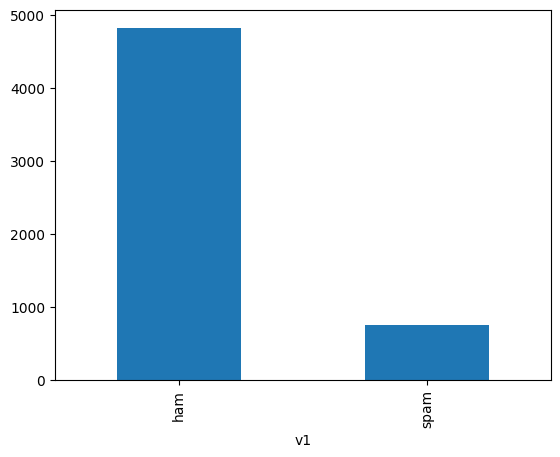

In [16]:
# class distribution analysis
dataset1['v1'].value_counts().plot(kind='bar')
plt.show()

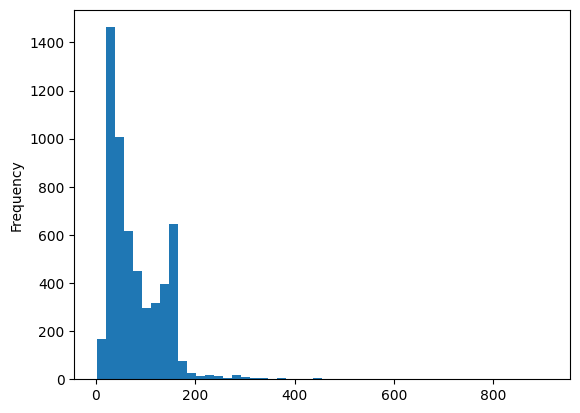

In [17]:
# MSG length analysis
dataset1['length'] = dataset1['v2'].apply(len)
dataset1['length'].plot(bins=50, kind='hist')
plt.show()

In [18]:
# handle missing values
dataset1.isnull().sum()

v1        0
v2        0
length    0
dtype: int64

In [19]:
# examine data types
dataset1.dtypes

v1        object
v2        object
length     int64
dtype: object

In [20]:
# use SMOTE to handle class imbalance
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
X = dataset1['v2']
y = dataset1['v1']  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_vec, y_train)
model = MultinomialNB()
model.fit(X_train_res, y_train_res)
y_pred = model.predict(X_test_vec)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.9730941704035875


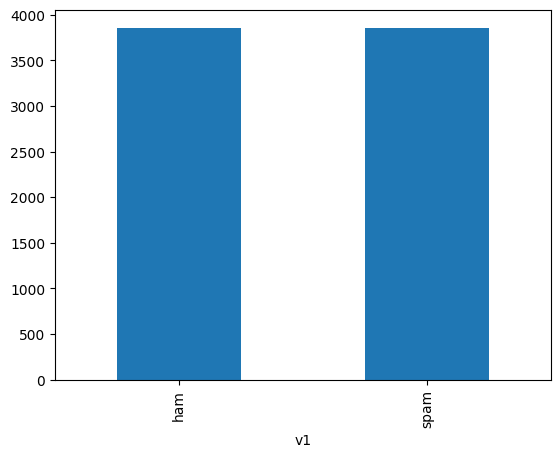

In [21]:
# analyzing the class distribution afetr SMOTE
y_train_res.value_counts().plot(kind='bar')
plt.show()

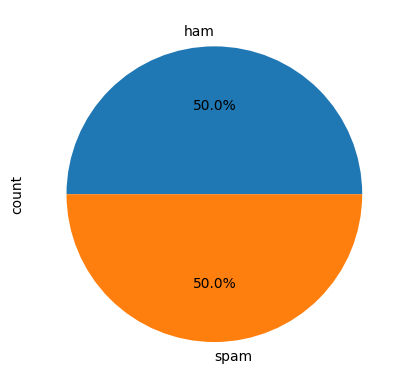

In [22]:
# class distribution pie chart
y_train_res.value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.show()

In [23]:
#  Print out a few examples of both spam and ham messages to get a qualitative sense of the differences in their content.
print("Spam Messages:")
print(dataset1[dataset1['v1'] == 'spam']['v2'].sample(5, random_state=42))
print("\nHam Messages:")
print(dataset1[dataset1['v1'] == 'ham']['v2'].sample(5, random_state=42))

Spam Messages:
1455    Summers finally here! Fancy a chat or flirt wi...
1852    This is the 2nd time we have tried 2 contact u...
672     Get ur 1st RINGTONE FREE NOW! Reply to this ms...
946     Ur cash-balance is currently 500 pounds - to m...
2879    Last Chance! Claim ur å£150 worth of discount ...
Name: v2, dtype: object

Ham Messages:
3714    I am late,so call you tomorrow morning.take ca...
1311    U r too much close to my heart. If u go away i...
548                                Wait  &lt;#&gt;  min..
1324    Can you call me plz. Your number shows out of ...
3184    MAYBE IF YOU WOKE UP BEFORE FUCKING 3 THIS WOU...
Name: v2, dtype: object


### Message Length Distribution Analysis

In [24]:
# create length feature
dataset1['length'] = dataset1['v2'].apply(len)
dataset1.head(10)

,v1,v2,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61
5,spam,FreeMsg Hey there darling it's been 3 week's n...,148
6,ham,Even my brother is not like to speak with me. ...,77
7,ham,As per your request 'Melle Melle (Oru Minnamin...,160
8,spam,WINNER!! As a valued network customer you have...,158
9,spam,Had your mobile 11 months or more? U R entitle...,154


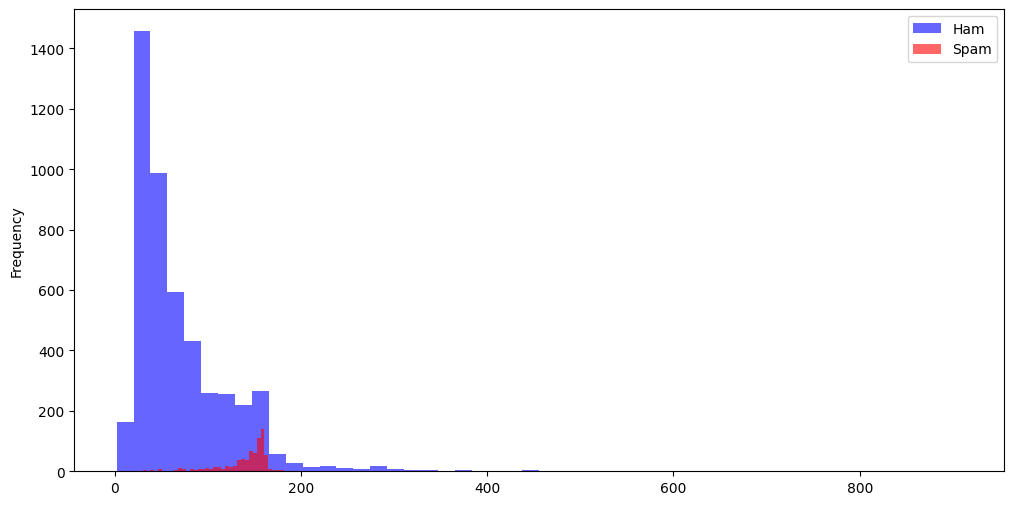

In [25]:
# comapre length distribution between spam and ham
plt.figure(figsize=(12, 6))
dataset1[dataset1['v1'] == 'ham']['length'].plot(bins=50, kind='hist', color='blue', alpha=0.6, label='Ham')
dataset1[dataset1['v1'] == 'spam']['length'].plot(bins=50, kind='hist', color='red', alpha=0.6, label='Spam')
plt.legend()

### Punctuation and spacial charecter analysis

In [26]:
# count punctuations
import string
dataset1['punctuation_count'] = dataset1['v2'].apply(lambda x: sum(1 for char in x if char in string.punctuation))
dataset1.head(10)

,v1,v2,length,punctuation_count
0,ham,"Go until jurong point, crazy.. Available only ...",111,9
1,ham,Ok lar... Joking wif u oni...,29,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,6
3,ham,U dun say so early hor... U c already then say...,49,6
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,2
5,spam,FreeMsg Hey there darling it's been 3 week's n...,148,8
6,ham,Even my brother is not like to speak with me. ...,77,2
7,ham,As per your request 'Melle Melle (Oru Minnamin...,160,6
8,spam,WINNER!! As a valued network customer you have...,158,6
9,spam,Had your mobile 11 months or more? U R entitle...,154,2


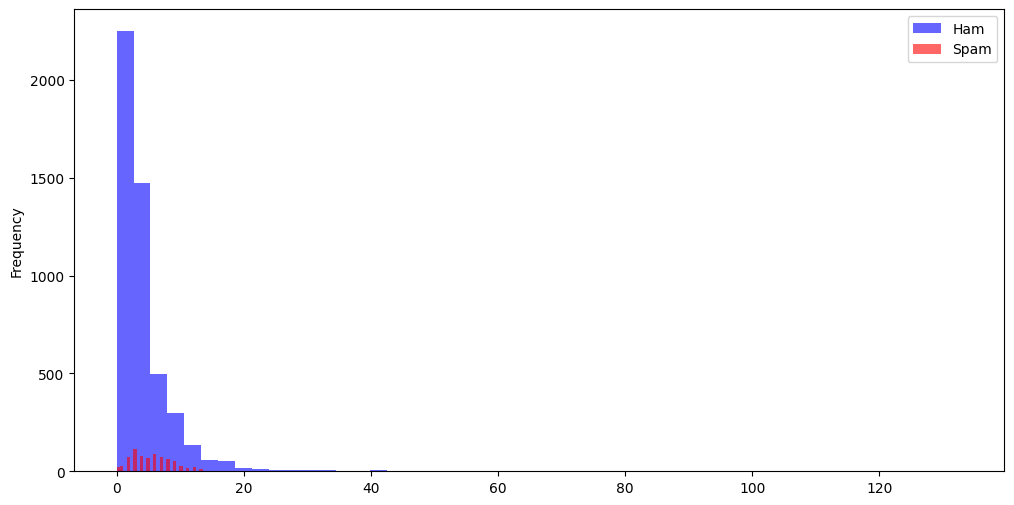

In [27]:
# compare counts per message between spam and ham
plt.figure(figsize=(12, 6))
dataset1[dataset1['v1'] == 'ham']['punctuation_count'].plot(bins=50, kind='hist', color='blue', alpha=0.6, label='Ham')
dataset1[dataset1['v1'] == 'spam']['punctuation_count'].plot(bins=50, kind='hist', color='red', alpha=0.6, label='Spam')
plt.legend()

### Word Level Analysis

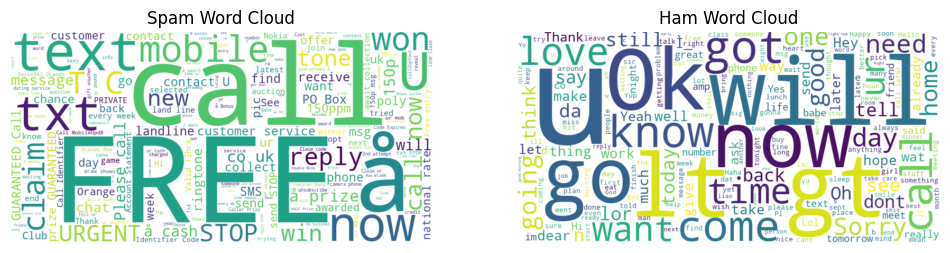

In [28]:
# create word clouds for spam and ham messages
from wordcloud import WordCloud
spam_words = ' '.join(dataset1[dataset1['v1'] == 'spam']['v2'])
ham_words = ' '.join(dataset1[dataset1['v1'] == 'ham']['v2'])
spam_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(spam_words)
ham_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(ham_words)
# Display the word clouds
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Spam Word Cloud')
plt.subplot(1, 2, 2)
plt.imshow(ham_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Ham Word Cloud')
plt.show()

In [29]:
# Comapre top n-grams between spam and ham messages
from sklearn.feature_extraction.text import CountVectorizer
def get_top_ngrams(corpus, n=None, ngram_range=(1, 1)):
    vec = CountVectorizer(ngram_range=ngram_range).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]
# Comapre top n-grams between spam and ham messages
from sklearn.feature_extraction.text import CountVectorizer 
def compare_spam_ham_ngrams(spam_corpus, ham_corpus, n=None, ngram_range=(1, 1)):
    spam_ngrams = get_top_ngrams(spam_corpus, n=n, ngram_range=ngram_range)
    ham_ngrams = get_top_ngrams(ham_corpus, n=n, ngram_range=ngram_range)
    return spam_ngrams, ham_ngrams
spam_corpus = dataset1[dataset1['v1'] == 'spam']['v2']
ham_corpus = dataset1[dataset1['v1'] == 'ham']['v2']
top_n = 20
spam_ngrams, ham_ngrams = compare_spam_ham_ngrams(spam_corpus, ham_corpus, n=top_n, ngram_range=(1, 2))
print(f"Top {top_n} Spam N-grams:")
for ngram, freq in spam_ngrams:
    print(f"  {ngram}: {freq}")
print(f"Top {top_n} Ham N-grams:")
for ngram, freq in ham_ngrams:
    print(f"  {ngram}: {freq}")

Top 20 Spam N-grams:
  to: 688
  call: 355
  you: 297
  your: 264
  free: 224
  the: 206
  for: 203
  now: 199
  or: 188
  txt: 163
  is: 158
  on: 144
  ur: 144
  have: 135
  from: 131
  mobile: 127
  text: 125
  and: 122
  stop: 121
  claim: 113
Top 20 Ham N-grams:
  you: 1943
  to: 1554
  the: 1122
  and: 857
  in: 818
  me: 772
  my: 750
  is: 732
  it: 711
  that: 551
  of: 525
  for: 501
  have: 440
  can: 439
  so: 435
  but: 434
  your: 417
  not: 415
  are: 414
  on: 393


In [30]:
# analyze case usages
def analyze_case_usages(corpus):
    case_usages = {}
    for text in corpus:
        for word in text.split():
            # Count the occurrences of each word with its case
            case_usages[word] = case_usages.get(word, 0) + 1
    return case_usages
spam_case_usages = analyze_case_usages(spam_corpus)
ham_case_usages = analyze_case_usages(ham_corpus)
spam_case_usages = analyze_case_usages(spam_corpus)
ham_case_usages = analyze_case_usages(ham_corpus)
print("Spam Case Usages (sample):", dict(list(spam_case_usages.items())[:10]))
print("Ham Case Usages (sample):", dict(list(ham_case_usages.items())[:10]))

Spam Case Usages (sample): {'Free': 35, 'entry': 25, 'in': 64, '2': 169, 'a': 358, 'wkly': 10, 'comp': 9, 'to': 604, 'win': 28, 'FA': 4}
Ham Case Usages (sample): {'Go': 10, 'until': 21, 'jurong': 1, 'point,': 1, 'crazy..': 1, 'Available': 1, 'only': 102, 'in': 734, 'bugis': 4, 'n': 128}


### Numerical and URL Analysis

In [31]:
# count numerical digits
import re
dataset1['digit_count'] = dataset1['v2'].apply(lambda x: len(re.findall(r'\d', x)))
dataset1.head(10)

,v1,v2,length,punctuation_count,digit_count
0,ham,"Go until jurong point, crazy.. Available only ...",111,9,0
1,ham,Ok lar... Joking wif u oni...,29,6,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,6,25
3,ham,U dun say so early hor... U c already then say...,49,6,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,2,0
5,spam,FreeMsg Hey there darling it's been 3 week's n...,148,8,4
6,ham,Even my brother is not like to speak with me. ...,77,2,0
7,ham,As per your request 'Melle Melle (Oru Minnamin...,160,6,1
8,spam,WINNER!! As a valued network customer you have...,158,6,19
9,spam,Had your mobile 11 months or more? U R entitle...,154,2,13


In [32]:
# count URLs
import re
def count_urls(text):
    url_pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    return len(re.findall(url_pattern, text))

dataset1['url_count'] = dataset1['v2'].apply(count_urls)
dataset1.head(60)

,v1,v2,length,punctuation_count,digit_count,url_count
0,ham,"Go until jurong point, crazy.. Available only ...",111,9,0,0
1,ham,Ok lar... Joking wif u oni...,29,6,0,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,6,25,0
3,ham,U dun say so early hor... U c already then say...,49,6,0,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,2,0,0
5,spam,FreeMsg Hey there darling it's been 3 week's n...,148,8,4,0
6,ham,Even my brother is not like to speak with me. ...,77,2,0,0
7,ham,As per your request 'Melle Melle (Oru Minnamin...,160,6,1,0
8,spam,WINNER!! As a valued network customer you have...,158,6,19,0
9,spam,Had your mobile 11 months or more? U R entitle...,154,2,13,0


<Axes: title={'center': 'URL Count'}, xlabel='v1', ylabel='url_count'>

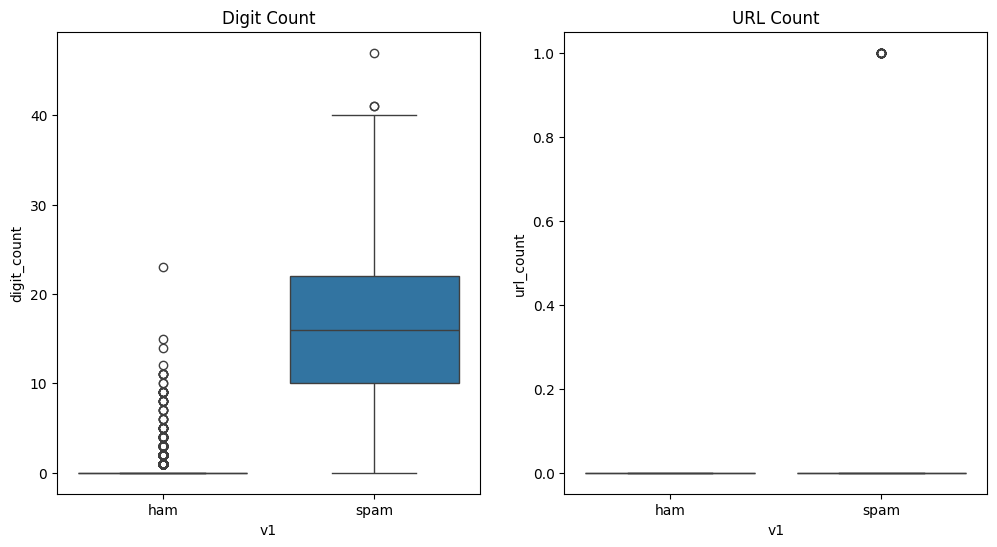

In [33]:
# compare counts per message between spam and ham
import seaborn as sns
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Digit Count")
sns.boxplot(x='v1', y='digit_count', data=dataset1)
plt.subplot(1, 2, 2)
plt.title("URL Count")
sns.boxplot(x='v1', y='url_count', data=dataset1)

### Linguistic Feature Analysis

In [34]:
# analyze abbreviations and slangs
abbreviations = {
    "u": "you",
    "ur": "your",
    "btw": "by the way",
    "idk": "I don't know",
    "imo": "in my opinion",
    "brb": "be right back",
    "lol": "laughing out loud",
    "omg": "oh my god",
    "ttyl": "talk to you later",
    "thx": "thanks",
    "pls": "please",
    "gr8": "great",
    "b4": "before",
    "l8r": "later",
    "cya": "see you",
    "np": "no problem",
    "smh": "shaking my head",
    "fyi": "for your information",
    "asap": "as soon as possible",
    "tbh": "to be honest",
    "imo": "in my opinion",
    "jk": "just kidding",
    "rofl": "rolling on the floor laughing",
    "wtf": "what the fuck",
    "yolo": "you only live once",
    "bff": "best friends forever",
    "irl": "in real life",
    "dm": "direct message",
    "ftw": "for the win",
    "fomo": "fear of missing out",
    "tmi": "too much information",
    "ily": "I love you",
    "xoxo": "hugs and kisses",
    "wyd": "what are you doing",
    "hbu": "how about you",
    "ikr": "I know right",
    "nvm": "never mind",
    "ppl": "people",
    "sry": "sorry",
    "thx": "thanks",
    "ty": "thank you",
    "yw": "you're welcome",
    "bc": "because",
    "cuz": "because",
    "bday": "birthday",
    "msg": "message",
    "txt": "text",
    "pic": "picture",
    "vid": "video",
    "atm": "at the moment",
    "bbl": "be back later",
    "cya": "see you",
    "fml": "fuck my life",
    "smh": "shaking my head",
    "tysm": "thank you so much"
}

In [35]:
# evaluate readability: For advanced analysis, compute readability scores. Some research suggests that spam messages have a lower readability score due to their simple language and structure.

def evaluate_readability(text):
    readability_score = textstat.flesch_kincaid_grade(text)
    return readability_score

In [36]:
dataset1.shape

(5572, 6)

In [37]:
X.shape

(5572,)

In [38]:
y.shape

(5572,)

# Advanced Preprocessing Pipeline

### Initial Cleaning

In [39]:
 # convert to lowercase
X = X.str.lower()

In [40]:
X.head()

0    go until jurong point, crazy.. available only ...
1                        ok lar... joking wif u oni...
2    free entry in 2 a wkly comp to win fa cup fina...
3    u dun say so early hor... u c already then say...
4    nah i don't think he goes to usf, he lives aro...
Name: v2, dtype: object

In [41]:
# Noise Removal
# replace URL with token like <url>
X = X.str.replace(r'http\S+|www\S+|https\S+', '<url>', case=False, regex=True)

# replace email with token like <email>
X = X.str.replace(r'\S+@\S+', '<email>', case=False, regex=True)

#replace phone numbers with token like <phone>
X = X.str.replace(r'\+?\d[\d -]{8,12}\d', '<phone>', case=False, regex=True)

In [42]:
# handle encoding issue
X = X.str.encode('utf-8', errors='ignore').str.decode('utf-8')
X.head(10)

0    go until jurong point, crazy.. available only ...
1                        ok lar... joking wif u oni...
2    free entry in 2 a wkly comp to win fa cup fina...
3    u dun say so early hor... u c already then say...
4    nah i don't think he goes to usf, he lives aro...
5    freemsg hey there darling it's been 3 week's n...
6    even my brother is not like to speak with me. ...
7    as per your request 'melle melle (oru minnamin...
8    winner!! as a valued network customer you have...
9    had your mobile 11 months or more? u r entitle...
Name: v2, dtype: object

In [43]:
# keep meaningful punctuations
X = X.str.replace(r'[^\w\s,.!?]', '', regex=True)
X.head(10)

0    go until jurong point, crazy.. available only ...
1                        ok lar... joking wif u oni...
2    free entry in 2 a wkly comp to win fa cup fina...
3    u dun say so early hor... u c already then say...
4    nah i dont think he goes to usf, he lives arou...
5    freemsg hey there darling its been 3 weeks now...
6    even my brother is not like to speak with me. ...
7    as per your request melle melle oru minnaminun...
8    winner!! as a valued network customer you have...
9    had your mobile 11 months or more? u r entitle...
Name: v2, dtype: object

### Feature Engineering

In [44]:
# currency and transaction tokenization
X = X.str.replace(r'\$\d+(\.\d{2})?', '<money>', regex=True)
X = X.str.replace(r'\d+%','<percentage>', regex=True)
X.head(10)

0    go until jurong point, crazy.. available only ...
1                        ok lar... joking wif u oni...
2    free entry in 2 a wkly comp to win fa cup fina...
3    u dun say so early hor... u c already then say...
4    nah i dont think he goes to usf, he lives arou...
5    freemsg hey there darling its been 3 weeks now...
6    even my brother is not like to speak with me. ...
7    as per your request melle melle oru minnaminun...
8    winner!! as a valued network customer you have...
9    had your mobile 11 months or more? u r entitle...
Name: v2, dtype: object

In [45]:
# capital letter ratio in the whole dataset
X = X.str.replace(r'([A-Z]{2,})', lambda m: m.group(1).lower(), regex=True)
X.head(10)

0    go until jurong point, crazy.. available only ...
1                        ok lar... joking wif u oni...
2    free entry in 2 a wkly comp to win fa cup fina...
3    u dun say so early hor... u c already then say...
4    nah i dont think he goes to usf, he lives arou...
5    freemsg hey there darling its been 3 weeks now...
6    even my brother is not like to speak with me. ...
7    as per your request melle melle oru minnaminun...
8    winner!! as a valued network customer you have...
9    had your mobile 11 months or more? u r entitle...
Name: v2, dtype: object

### Advanced Text processing

### Word Level Tokenization

In [46]:
from nltk.tokenize import word_tokenize
import nltk

# Download required NLTK data
nltk.download('punkt_tab', quiet=True)

def safe_tokenize(text):
    try:
        return word_tokenize(str(text))
    except Exception as e:
        print(f"Error tokenizing text: {e}")
        return str(text).split()

# Apply tokenization
print("Tokenizing messages...")
X = X.apply(safe_tokenize)
print("Tokenization complete!\n")
print("Sample tokenized messages:")
print(X.head())

Tokenizing messages...
Tokenization complete!

Sample tokenized messages:
0    [go, until, jurong, point, ,, crazy, .., avail...
1             [ok, lar, ..., joking, wif, u, oni, ...]
2    [free, entry, in, 2, a, wkly, comp, to, win, f...
3    [u, dun, say, so, early, hor, ..., u, c, alrea...
4    [nah, i, dont, think, he, goes, to, usf, ,, he...
Name: v2, dtype: object


In [47]:
# stop word removal
from nltk.corpus import stopwords
nltk.download('stopwords', quiet=True)
stop_words = set(stopwords.words('english'))
X = X.apply(lambda tokens: [word for word in tokens if word not in stop_words])
X.head(10)

0    [go, jurong, point, ,, crazy, .., available, b...
1             [ok, lar, ..., joking, wif, u, oni, ...]
2    [free, entry, 2, wkly, comp, win, fa, cup, fin...
3    [u, dun, say, early, hor, ..., u, c, already, ...
4    [nah, dont, think, goes, usf, ,, lives, around...
5    [freemsg, hey, darling, 3, weeks, word, back, ...
6    [even, brother, like, speak, ., treat, like, a...
7    [per, request, melle, melle, oru, minnaminungi...
8    [winner, !, !, valued, network, customer, sele...
9    [mobile, 11, months, ?, u, r, entitled, update...
Name: v2, dtype: object

### lemmatization

In [48]:
# accurate lemmatization using WordNetLemmatizer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
lemmatizer = WordNetLemmatizer()
X = X.apply(lambda tokens: [lemmatizer.lemmatize(word) for word in tokens])
X.head(10)

0    [go, jurong, point, ,, crazy, .., available, b...
1             [ok, lar, ..., joking, wif, u, oni, ...]
2    [free, entry, 2, wkly, comp, win, fa, cup, fin...
3    [u, dun, say, early, hor, ..., u, c, already, ...
4    [nah, dont, think, go, usf, ,, life, around, t...
5    [freemsg, hey, darling, 3, week, word, back, !...
6    [even, brother, like, speak, ., treat, like, a...
7    [per, request, melle, melle, oru, minnaminungi...
8    [winner, !, !, valued, network, customer, sele...
9    [mobile, 11, month, ?, u, r, entitled, update,...
Name: v2, dtype: object

### Spelling  Correction

In [49]:
# spelling correction
from textblob import TextBlob

def correct_spelling(text):
    try:
        return str(TextBlob(text).correct())
    except Exception as e:
        print(f"Error correcting spelling: {e}")
        return text

# Apply spelling correction
print("Correcting spelling...")
X = X.apply(lambda tokens: [correct_spelling(word) for word in tokens])
print("Spelling correction complete!\n")
print("Sample corrected messages:")
print(X.head(10))

Correcting spelling...
Spelling correction complete!

Sample corrected messages:
0    [go, during, point, ,, crazy, .., available, b...
1               [ok, war, ..., joking, if, u, on, ...]
2    [free, entry, 2, wily, come, win, a, cup, fina...
3    [u, dun, say, early, for, ..., u, c, already, ...
4    [ah, dont, think, go, us, ,, life, around, tho...
5    [freemen, hey, darling, 3, week, word, back, !...
6    [even, brother, like, speak, ., treat, like, a...
7    [per, request, selle, selle, or, minnaminungin...
8    [winner, !, !, valued, network, customer, sele...
9    [mobile, 11, month, ?, u, r, entitled, update,...
Name: v2, dtype: object


In [50]:
from transformers import BertTokenizer

# Load the BERT tokenizer for uncased English text
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_and_pad(texts, max_length=512):
    """
    Tokenize, truncate, and pad: Convert text messages into input IDs and an attention mask.
    Add special tokens ([CLS] at the beginning and [SEP] at the end) as BERT expects.
    Truncate longer sequences that exceed BERT's maximum sequence length (typically 512 tokens).
    Pad shorter sequences with [PAD] tokens so that all messages have the same length.
    
    Args:
        texts: List, pandas Series, or DataFrame of text strings to tokenize. If DataFrame, uses the first column.
        max_length: Maximum sequence length for truncation and padding.
    
    Returns:
        Dict with 'input_ids' and 'attention_mask' as PyTorch tensors.
    """
    # Handle DataFrame input by selecting the first text column
    if hasattr(texts, 'columns'):
        texts = texts.iloc[:, 0]
    
    # Ensure texts is a list of strings, handling potential nested sequences
    tokenized_texts = []
    for item in texts:
        if isinstance(item, (list, tuple)):
            # Join nested sequences into a single string
            tokenized_texts.append(' '.join(str(subitem) for subitem in item))
        else:
            tokenized_texts.append(str(item))
    
    # Tokenize and encode the texts: adds special tokens, truncates, and pads
    encodings = tokenizer(
        tokenized_texts,
        truncation=True,
        padding=True,
        max_length=max_length,
        return_tensors='pt'
    )
    
    # The encodings include input_ids (token indices) and attention_mask (1s for real tokens, 0s for padding)
    return encodings

# Assuming X is a list, Series, or DataFrame of text messages
X = tokenize_and_pad(X)

c:\Users\bdcalling123\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [51]:
# show te head of the tokenized and padded input IDs
print(X['input_ids'][:10])

tensor([[ 101, 2175, 2076,  ...,    0,    0,    0],
        [ 101, 7929, 2162,  ...,    0,    0,    0],
        [ 101, 2489, 4443,  ...,    0,    0,    0],
        ...,
        [ 101, 2566, 5227,  ...,    0,    0,    0],
        [ 101, 3453,  999,  ...,    0,    0,    0],
        [ 101, 4684, 2340,  ...,    0,    0,    0]])


### Create Attention Masks

In [52]:
from transformers import BertTokenizer

# Load the BERT tokenizer for uncased English text
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_and_pad(texts, max_length=512):
    # Handle DataFrame input by selecting the first text column
    if hasattr(texts, 'columns'):
        texts = texts.iloc[:, 0]
    
    # Ensure texts is a list of strings, handling potential nested sequences
    tokenized_texts = []
    for item in texts:
        if isinstance(item, (list, tuple)):
            # Join nested sequences into a single string
            tokenized_texts.append(' '.join(str(subitem) for subitem in item))
        else:
            tokenized_texts.append(str(item))
    
    # Tokenize and encode the texts: adds special tokens, truncates, and pads
    encodings = tokenizer(
        tokenized_texts,
        truncation=True,
        padding=True,
        max_length=max_length,
        return_tensors='pt'
    )
    
    # The encodings include input_ids (token indices) and attention_mask (1s for real tokens, 0s for padding)
    return encodings

# Assuming X is a list, Series, or DataFrame of text messages
X = tokenize_and_pad(X)

# Note: X['attention_mask'] is already available and equivalent to the manual computation below.
# Create attention masks: Generate an attention mask to distinguish real tokens from padding tokens.
# This is a binary array indicating whether the model should "pay attention" to a token (1) or ignore it (0).
attention_masks = (X['input_ids'] != tokenizer.pad_token_id).long()
attention_masks[:10]

tensor([[1, 1, 1, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 0]])

### Data Augtmentation

In [ ]:
# using data augmentation To improve the model's robustness and accuracy on a small mobile device, use techniques like synonym replacement or back-translation to generate more training examples.


In [53]:
# Install required packages for data augmentation
!pip install nlpaug


   ------------- -------------------------- 1/3 [gdown]
   -------------------------- ------------- 2/3 [nlpaug]
   -------------------------- ------------- 2/3 [nlpaug]
   -------------------------- ------------- 2/3 [nlpaug]
   -------------------------- ------------- 2/3 [nlpaug]
   -------------------------- ------------- 2/3 [nlpaug]
   -------------------------- ------------- 2/3 [nlpaug]
   -------------------------- ------------- 2/3 [nlpaug]
   -------------------------- ------------- 2/3 [nlpaug]
   -------------------------- ------------- 2/3 [nlpaug]
   -------------------------- ------------- 2/3 [nlpaug]
   ---------------------------------------- 3/3 [nlpaug]



In [54]:
import nlpaug.augmenter.word as naw
import nltk
import random

# Download required NLTK data
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

def augment_text_with_synonyms(text, n_aug=1):
    """
    Augment text using synonym replacement
    Args:
        text: Input text string
        n_aug: Number of augmented versions to generate
    Returns:
        List of augmented texts
    """
    # Initialize augmenter
    aug = naw.SynonymAug(aug_src='wordnet')
    
    try:
        # Generate augmented versions
        augmented_texts = [aug.augment(text)[0] for _ in range(n_aug)]
        return augmented_texts
    except Exception as e:
        print(f"Error in augmentation: {e}")
        return [text]  # Return original text if augmentation fails

# Test the function
sample_text = "Hello, how are you today? I am feeling great!"
augmented = augment_text_with_synonyms(sample_text, n_aug=2)
print("Original:", sample_text)
print("Augmented versions:")
for i, aug_text in enumerate(augmented, 1):
    print(f"{i}:", aug_text)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\bdcalling123\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\bdcalling123\AppData\Roaming\nltk_data...


Error in augmentation: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng

  Searched in:
    - 'C:\\Users\\bdcalling123/nltk_data'
    - 'c:\\Users\\bdcalling123\\AppData\\Local\\Programs\\Python\\Python313\\nltk_data'
    - 'c:\\Users\\bdcalling123\\AppData\\Local\\Programs\\Python\\Python313\\share\\nltk_data'
    - 'c:\\Users\\bdcalling123\\AppData\\Local\\Programs\\Python\\Python313\\lib\\nltk_data'
    - 'C:\\Users\\bdcalling123\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************

Original: Hello, how are you today? I am feeling great!
Augmented v

[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\bdcalling123\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [57]:
dataset1.head()

,v1,v2,length,punctuation_count,digit_count,url_count
0,ham,"Go until jurong point, crazy.. Available only ...",111,9,0,0
1,ham,Ok lar... Joking wif u oni...,29,6,0,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,6,25,0
3,ham,U dun say so early hor... U c already then say...,49,6,0,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,2,0,0


# Model Architecture Design

In [59]:
!pip install hf_xet

   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   --- ------------------------------------ 0.3/2.8 MB ? eta -:--:--
   ---------------------------------------- 2.8/2.8 MB 12.5 MB/s  0:00:00


In [60]:
# using distilBERT model from huggingface: use distilbert-base-uncased
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [61]:
# define classification head :Add a classification head (a dense layer) on top of the DistilBERT model specifically for the spam/ham binary classification task
import torch
class SpamHamClassifier(torch.nn.Module):
    def __init__(self, distilbert_model):
        super(SpamHamClassifier, self).__init__()
        self.distilbert = distilbert_model
        self.classifier = torch.nn.Linear(self.distilbert.config.hidden_size, 2)  # Binary classification (spam vs ham)
    
    def forward(self, input_ids, attention_mask):
        outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = outputs.last_hidden_state  # (batch_size, sequence_length, hidden_size)
        pooled_output = hidden_state[:, 0]  # Take the representation of [CLS] token
        logits = self.classifier(pooled_output)  # (batch_size, num_labels)
        return logits
classifier_model = SpamHamClassifier(model)

# Fine Tuning the Model

In [67]:
!pip3 install torch torchvision torchaudio

  Using cached torchvision-0.23.0-cp313-cp313-win_amd64.whl.metadata (6.1 kB)
Using cached torchvision-0.23.0-cp313-cp313-win_amd64.whl (1.6 MB)
   ---------------------------------------- 0.0/2.5 MB ? eta -:--:--
   ---------------------------------------- 2.5/2.5 MB 60.3 MB/s  0:00:00

   ---------------------------------------- 0/2 [torchvision]
   ---------------------------------------- 0/2 [torchvision]
   ---------------------------------------- 0/2 [torchvision]
   ---------------------------------------- 0/2 [torchvision]
   ---------------------------------------- 0/2 [torchvision]
   ---------------------------------------- 0/2 [torchvision]
   ---------------------------------------- 0/2 [torchvision]
   ---------------------------------------- 0/2 [torchvision]
   ---------------------------------------- 0/2 [torchvision]
   ---------------------------------------- 0/2 [torchvision]
   ---------------------------------------- 0/2 [torchvision]
   --------------------------

In [74]:
# Model fine-tuning
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW  # Import AdamW from torch.optim instead of transformers
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from tqdm.notebook import tqdm

# Prepare dataset for PyTorch
# Ensure input_ids, attention_mask, and labels are all the same length
input_ids = X['input_ids']
attention_mask = X['attention_mask']
labels = torch.tensor(y.map({'ham': 0, 'spam': 1}).values)

# Convert tensors to numpy arrays for splitting
input_ids_np = input_ids.cpu().numpy()
attention_mask_np = attention_mask.cpu().numpy()
labels_np = labels.cpu().numpy()

# Check shapes before splitting
print('input_ids shape:', input_ids_np.shape)
print('attention_mask shape:', attention_mask_np.shape)
print('labels shape:', labels_np.shape)

# Split the data into training and validation sets
from sklearn.model_selection import train_test_split
train_inputs, val_inputs, train_masks, val_masks, train_labels, val_labels = train_test_split(
    input_ids_np, attention_mask_np, labels_np, test_size=0.1, random_state=42
)
train_inputs = torch.tensor(train_inputs)
val_inputs = torch.tensor(val_inputs)
train_masks = torch.tensor(train_masks)
val_masks = torch.tensor(val_masks)
train_labels = torch.tensor(train_labels)
val_labels = torch.tensor(val_labels)

# Create DataLoader for training
train_dataset = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Create DataLoader for validation
val_dataset = TensorDataset(val_inputs, val_masks, val_labels)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define optimizer and loss function
optimizer = AdamW(classifier_model.parameters(), lr=2e-5)  # Lower learning rate for more stable training
loss_fn = torch.nn.CrossEntropyLoss()

# Training settings
epochs = 3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
classifier_model = classifier_model.to(device)

# Initialize lists to store metrics
train_losses = []
val_losses = []
val_accuracies = []

print(f"Training on {device}")

# Training loop with progress tracking
for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    
    # Training phase
    classifier_model.train()
    total_train_loss = 0
    progress_bar = tqdm(train_dataloader, desc="Training")
    
    for batch in progress_bar:
        b_input_ids, b_attention_mask, b_labels = [b.to(device) for b in batch]
        
        optimizer.zero_grad()
        
        # Forward pass
        logits = classifier_model(b_input_ids, b_attention_mask)
        loss = loss_fn(logits, b_labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
        progress_bar.set_postfix({'train_loss': f'{loss.item():.4f}'})
    
    avg_train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    
    # Validation phase
    classifier_model.eval()
    total_val_loss = 0
    val_preds = []
    val_true = []
    
    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc="Validation"):
            b_input_ids, b_attention_mask, b_labels = [b.to(device) for b in batch]
            
            logits = classifier_model(b_input_ids, b_attention_mask)
            loss = loss_fn(logits, b_labels)
            
            total_val_loss += loss.item()
            
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            val_preds.extend(preds)
            val_true.extend(b_labels.cpu().numpy())
    
    avg_val_loss = total_val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)
    
    val_accuracy = accuracy_score(val_true, val_preds)
    val_accuracies.append(val_accuracy)
    
    print(f"\nAverage training loss: {avg_train_loss:.4f}")
    print(f"Average validation loss: {avg_val_loss:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    print("\nValidation Classification Report:")
    print(classification_report(val_true, val_preds, target_names=['ham', 'spam']))

input_ids shape: (3, 8)
attention_mask shape: (3, 8)
labels shape: (5572,)


ValueError: Found input variables with inconsistent numbers of samples: [3, 3, 5572]

In [73]:
# DEBUG: Check shapes and types before splitting
print('Type of X:', type(X))
if isinstance(X, dict):
    print('X keys:', X.keys())
    print('input_ids shape:', X['input_ids'].shape)
    print('attention_mask shape:', X['attention_mask'].shape)
else:
    print('X shape:', getattr(X, 'shape', 'N/A'))
print('Type of y:', type(y))
print('y shape:', getattr(y, 'shape', 'N/A'))
print('First 5 y values:', y[:5])
print('input_ids sample:', X['input_ids'][:2] if isinstance(X, dict) else X[:2])

Type of X: <class 'transformers.tokenization_utils_base.BatchEncoding'>
X shape: N/A
Type of y: <class 'pandas.core.series.Series'>
y shape: (5572,)
First 5 y values: 0     ham
1     ham
2    spam
3     ham
4     ham
Name: v1, dtype: object
input_ids sample: {'input_ids': tensor([[  101,  7953,  1035,  8909,  2015,   102,     0,     0],
        [  101, 19204,  1035,  2828,  1035,  8909,  2015,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1]])}


In [ ]:
# Plot training metrics
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot validation accuracy
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()